# Clustering Yelp Restaurants

**Part 1: To be completed INDIVIDUALLY and due on October 14 at 7pm.**

In this assignment, we will be working with the [Yelp dataset](https://drive.google.com/open?id=0B4bdB5WPHGsqcmJMNmxzQmQ3aTQ). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

From the Business Objects, let's try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" to cluster for similarity. You may want to use only a subset (15-20) of popular categories.

Note that the spatial coordinates and restaurant categories have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

In [1]:
import json
import math
# Load Json file
data = []
for line in open('yelp_academic_dataset_business.json', 'r'):
    data.append(json.loads(line))

In [2]:
# Parse json: Address contains Lag Vegas && categories contains restuarant
parsed_data = []
for x in data:
    if (x['city'] == 'Las Vegas' and 'Restaurants' in x['categories']):
        parsed_data.append(x)

Scaling clarification:
Algorithm:
1. Calculate the means of longitude and latitude
2. Classify the longitude and latitude into 4 sets, Northwest, NorthEast, SouthEast, SouthWest, use the means to classify the corresponding data
3. Add the location feature to str_list
4. While 2 - 4 until all data location feature is setted
Example:
original data = {seafood, sushi}
scaling data = {seafood, sushi, northwest}

In [3]:
str_list = []
longitude_sum = 0
latitude_sum = 0
for x in parsed_data:
    longitude_sum = longitude_sum + math.fabs(x['longitude'])
    latitude_sum = latitude_sum + x['latitude']

longitude_ave = longitude_sum / len(parsed_data)
latitude_ave = latitude_sum / len(parsed_data)

for x in parsed_data:
    str1 = ''
    str1 = " ".join(x['categories'])
    if (math.fabs(x['longitude']) >= longitude_ave and x['latitude'] >= latitude_ave):
        str1 = str1 + ' ' + 'NorthWest' 
    elif (math.fabs(x['longitude']) < longitude_ave and x['latitude'] > latitude_ave):
        str1 = str1 + ' ' + 'NorthEast'
    elif (math.fabs(x['longitude']) > longitude_ave and x['latitude'] < latitude_ave):
        str1 = str1 + ' ' + 'SouthWest' 
    elif (math.fabs(x['longitude']) < longitude_ave and x['latitude'] < latitude_ave):
        str1 = str1 + ' ' + 'SouthEast' 
    str_list.append(str1)

Vectorize the data

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 1)
D = vectorizer.fit_transform(str_list)

# X is cosine similarity
X = (D* D.T).toarray()

K Means Parameter Clarification:
Use error function to decide how many cluster to be used in k-means
evaluate function reference: class ppt

In [5]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def evaluate_clusters(X, max_clusters):
    error = np.zeros(max_clusters + 1)
    error[0] = 0;
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
        kmeans.fit_predict(X)
        error[k] = kmeans.inertia_
        plt.xlabel('Number of clusters')
        plt.ylabel('Error')
    
    plt.plot(range(1,len(error)), error[1:])

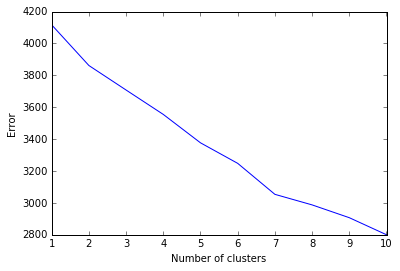

In [6]:
evaluate_clusters(D, 10)

We can see the curve goes gently when k = 9, so we use 9 cluster for k-means

In [7]:
k = 9
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
kmeans_predict = kmeans.fit_predict(D)

K means data explanation
A list of top terms in each cluster
We can draw a brief culinary district conclusion from the data
For example, in cluster 2, there are 'wings', 'chicken', 'fast', 'pizza', 'southwest/east' as top terms, we can say cluster 2 is a Fast food culinary district in south area
For another example, in cluster 4, there are 'korea', 'sushi', 'asian', 'japanese', 'south/northwest' so we can say cluster 4 is an asia culinary district in west area

In [8]:
# Calculate the K-means
# Reference: Class PPT
print("K means")
print("Top terms per cluster:")
asc_order_centroids = kmeans.cluster_centers_.argsort()#[:, ::-1]
order_centroids = asc_order_centroids[:,::-1]
terms = vectorizer.get_feature_names()
for i in range(k):
    print("Cluster {}:".format(i))
    for ind in order_centroids[i, :10]:
        print(' {}'.format(terms[ind]))
    print('')

K means
Top terms per cluster:
Cluster 0:
 bars
 nightlife
 american
 sports
 traditional
 restaurants
 southeast
 new
 pubs
 northwest

Cluster 1:
 mexican
 southwest
 restaurants
 chinese
 northeast
 southeast
 vietnamese
 korean
 thai
 seafood

Cluster 2:
 northeast
 new
 american
 restaurants
 southeast
 chinese
 steakhouses
 food
 cafes
 italian

Cluster 3:
 northwest
 restaurants
 pizza
 mexican
 chinese
 italian
 thai
 barbeque
 food
 cafes

Cluster 4:
 southeast
 pizza
 restaurants
 italian
 chinese
 steakhouses
 southwest
 burgers
 northeast
 seafood

Cluster 5:
 sandwiches
 restaurants
 southeast
 northwest
 southwest
 delis
 pizza
 northeast
 salad
 food

Cluster 6:
 fast
 food
 restaurants
 burgers
 sandwiches
 northwest
 southeast
 mexican
 northeast
 southwest

Cluster 7:
 japanese
 sushi
 bars
 restaurants
 southwest
 southeast
 northwest
 asian
 fusion
 ramen

Cluster 8:
 traditional
 american
 restaurants
 southeast
 breakfast
 brunch
 northwest
 northeast
 burgers
 so

hierarchical clustering

In [9]:
import scipy.cluster.hierarchy as hac

z = hac.linkage(D.toarray(), 'ward')

print(z)

[[  0.00000000e+00   2.41000000e+02   0.00000000e+00   2.00000000e+00]
 [  1.00000000e+00   3.00100000e+03   0.00000000e+00   2.00000000e+00]
 [  2.00000000e+00   2.06000000e+02   0.00000000e+00   2.00000000e+00]
 ..., 
 [  9.30600000e+03   9.31100000e+03   1.88811279e+01   3.57900000e+03]
 [  9.29000000e+03   9.30800000e+03   1.96256088e+01   1.07900000e+03]
 [  9.31200000e+03   9.31300000e+03   2.00871514e+01   4.65800000e+03]]


{'color_list': ['g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',
  'g',

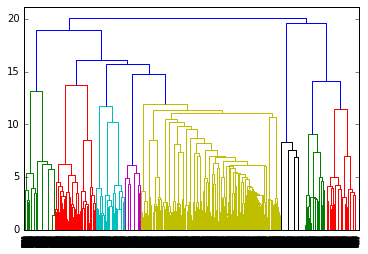

In [10]:
hac.dendrogram(z)
# Here we can see the dendrogram, note: scroll down of the output

Hierarchy clustering Parameter Clarify: 
As we can see from the dendrogram, the cluster goes clear when the number of clusters is over 10, so we pick 10 as the max cluster

In [11]:
T = hac.fcluster(z, 10, 'maxclust')
print(T)

[3 5 2 ..., 3 7 5]


In [12]:
hierarchy_result = [None]*10
for i in range(0, len(T)):
    if (hierarchy_result[T[i]-1] is None):
        hierarchy_result[T[i]-1] = []
    else:
        if (parsed_data[i]['categories'][0] in hierarchy_result[T[i] - 1]):
            continue
        hierarchy_result[T[i]-1].append(parsed_data[i]['categories'][0])

Hierarchy cluster data representation
From the below print, we can see a hierarchy cluster through agglomerative
cluster 0 is the highest cluster, and the top feature is restaurants, Italian, Pizza, which is reasonable because most restaurants have these 3 tagsWe can say these three tags belongs to the a huge number of restaurant in Las Vegas
And when we go down to the cluster 3, we find the top term is Japanese, Sushi
When we go down to cluster 5, we see chinese as a top term
From hierarchy cluster we get the top 10 culinary district with most popular tags

In [59]:
print("Hierarchy Cluster")
print("Top terms per cluster:")

for i in range(10):
    print("Cluster {}:".format(i))
    new_result = hierarchy_result[i]
    for ind in new_result[0: 3]:
        print(' {}'.format(ind))
    print('')

Hierarchy Cluster
Top terms per cluster:
Cluster 0:
 Restaurants
 Italian
 Pizza

Cluster 1:
 Pizza

Cluster 2:
 Pubs
 Bars
 Nightlife

Cluster 3:
 Japanese
 Sushi Bars
 Steakhouses

Cluster 4:
 American (Traditional)
 Breakfast & Brunch
 Burgers

Cluster 5:
 Chinese
 Dim Sum
 Asian Fusion

Cluster 6:
 Latin American
 Vietnamese
 Chinese

Cluster 7:
 Mexican

Cluster 8:
 Fast Food
 Sandwiches
 Restaurants

Cluster 9:
 Burgers
 Fast Food
 Pub Food



GMM Calculation

GMM Parameter Clarification:
We use BIC(Bayessian Information Crietia) to decide the components number of GMM, here we pick 9 components as BIC curve goes gently at this number

In [14]:
# Calculate GMM
from sklearn import mixture

gmix = mixture.GMM(n_components=9, covariance_type='full')
gmix.fit(D.toarray())
print(gmix.means_)

[[  1.19224258e-147   7.84593184e-101   4.07413440e-094 ...,
    6.60445260e-004   2.89459439e-109   8.78781507e-127]
 [  3.60972138e-154   2.10308252e-090   6.05098265e-105 ...,
    7.91193278e-003   9.37729096e-140   2.45267922e-147]
 [  1.72613724e-003   1.53805671e-003   8.56080498e-151 ...,
    1.14583635e-002   6.94878847e-158   5.18497444e-147]
 ..., 
 [  3.84677059e-169   9.87046043e-145   1.49936675e-159 ...,
    2.54369729e-114   1.29438737e-148   1.92975760e-149]
 [  7.17742504e-155   1.82452540e-097   2.97569528e-097 ...,
    2.07222181e-096   9.22000757e-157   3.69211730e-156]
 [  4.15480370e-003   2.13378333e-122   1.00412687e-002 ...,
    1.29683098e-003   3.15295303e-002   3.25862095e-003]]


In [15]:
GT = gmix.fit_predict(D.toarray())

In [16]:
gmm_result = [None]*9
for i in range(0, len(GT)):
    if (gmm_result[GT[i]-1] is None):
        gmm_result[GT[i]-1] = []
    else:
        if (parsed_data[i]['categories'][0] in gmm_result[GT[i] - 1]):
            continue
        gmm_result[GT[i]-1].append(parsed_data[i]['categories'][0])

GMM Data representation
We have 9 components of the culinary district
Since some of the category may have overlap (i.e Chinese food, Japanese food), so GMM can help us prevent the misclassify when tags overlap happens 
The data in the 9 components represent 9 culinary district in the city, we can see a data sample with top tags in below

In [17]:
print("GMM Cluster")
print("Top terms per cluster:")

for i in range(9):
    print("Cluster {}:".format(i))
    new_result = gmm_result[i]
    for ind in new_result[0: 5]:
        print(' {}'.format(ind))
    print('')

GMM Cluster
Top terms per cluster:
Cluster 0:
 Burgers
 Food
 Latin American
 Breakfast & Brunch
 Cafes

Cluster 1:
 Mexican
 Fast Food
 Bakeries
 Cuban
 Seafood

Cluster 2:
 Fast Food
 American (Traditional)
 Burgers
 Breakfast & Brunch
 Food

Cluster 3:
 Pubs
 Bars
 Nightlife
 Dive Bars
 Soul Food

Cluster 4:
 Korean
 Hawaiian
 Sushi Bars
 Seafood
 Japanese

Cluster 5:
 Vietnamese
 Chinese
 Buffets
 Fast Food
 Thai

Cluster 6:
 Chinese
 Vegetarian
 Pakistani
 Kosher
 Persian/Iranian

Cluster 7:
 Delis
 Restaurants
 Pizza
 Italian
 Sandwiches

Cluster 8:
 Sandwiches
 Fast Food
 American (Traditional)
 Chicken Wings
 Delis



Visualize the clusters by plotting the longitude/latitude of the restaurants in a scatter plot. Label each cluster with a category. In a markdown, explain how labels are assigned. **(10 pts)**

Note that some categories are inherently more common (e.g. "pizza"). When labeling your clusters, you want to avoid the scenario where all clusters are labeled as "pizza" simply because of the uniformly large number of these restaurants across all clusters. In other words, we don’t want to point out that pizza restaurants are pretty much evenly distributed in high quantities everywhere, but rather discover when they, or another type of restaurant, appear in notably high quantities.

How labels are assigned:
The labels of each cluster are assigned with the center's corresponding category's first element.
For kmeans we can use center function directly. For Hierarchical and GMM, we calculate the center (count the top words).

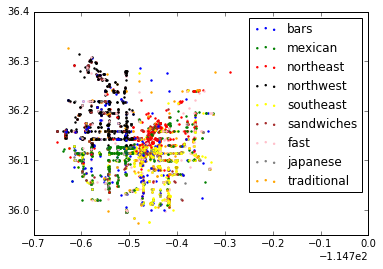

In [18]:
# K-Means scatter plot
colors = ['blue', 'green', 'red', 'black', 'yellow', 'brown', 'pink', 'grey', 'orange']
for i in range(0, len(parsed_data)):
    X = parsed_data[i]['longitude']
    Y = parsed_data[i]['latitude']
    if (kmeans.labels_[i] == 0):
        plta = plt.scatter(x = X, y = Y, color = colors[0], s = 2)
    elif (kmeans.labels_[i] == 1):
        pltb = plt.scatter(x = X, y = Y, color = colors[1], s = 2)
    elif (kmeans.labels_[i] == 2):
        pltc = plt.scatter(x = X, y = Y, color = colors[2], s = 2)
    elif (kmeans.labels_[i] == 3):
        pltd = plt.scatter(x = X, y = Y, color = colors[3], s = 2)
    elif (kmeans.labels_[i] == 4):
        plte = plt.scatter(x = X, y = Y, color = colors[4], s = 2)
    elif (kmeans.labels_[i] == 5):
        pltf = plt.scatter(x = X, y = Y, color = colors[5], s = 2)
    elif (kmeans.labels_[i] == 6):
        pltg = plt.scatter(x = X, y = Y, color = colors[6], s = 2)
    elif (kmeans.labels_[i] == 7):
        plth = plt.scatter(x = X, y = Y, color = colors[7], s = 2)
    elif (kmeans.labels_[i] == 8):
        plti = plt.scatter(x = X, y = Y, color = colors[8], s = 2)
plt.scatter(x = -114.8, y = 36.35, s=0)
plt.legend((plta, pltb, pltc, pltd, plte, pltf, pltg, plth, plti), 
           (terms[order_centroids[0, 0]], 
            terms[order_centroids[1, 0]], 
            terms[order_centroids[2, 0]], 
            terms[order_centroids[3, 0]],
            terms[order_centroids[4, 0]],
            terms[order_centroids[5, 0]],
            terms[order_centroids[6, 0]],
            terms[order_centroids[7, 0]],
            terms[order_centroids[8, 0]]))

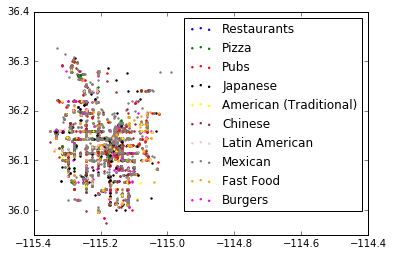

In [19]:
# Hierarchical scatter plot
# 
T = hac.fcluster(z, 10, 'maxclust')
colors = ['blue', 'green', 'red', 'black', 'yellow', 'brown', 'pink', 'grey', 'orange', 'magenta']
for i in range(0, len(parsed_data)):
    X = parsed_data[i]['longitude']
    Y = parsed_data[i]['latitude']
    if (T[i] == 0):
        plta = plt.scatter(x = X, y = Y, color = colors[0], s = 2)
    elif (T[i] == 1):
        pltb = plt.scatter(x = X, y = Y, color = colors[1], s = 2)
    elif (T[i] == 2):
        pltc = plt.scatter(x = X, y = Y, color = colors[2], s = 2)
    elif (T[i] == 3):
        pltd = plt.scatter(x = X, y = Y, color = colors[3], s = 2)
    elif (T[i] == 4):
        plte = plt.scatter(x = X, y = Y, color = colors[4], s = 2)
    elif (T[i] == 5):
        pltf = plt.scatter(x = X, y = Y, color = colors[5], s = 2)
    elif (T[i] == 6):
        pltg = plt.scatter(x = X, y = Y, color = colors[6], s = 2)
    elif (T[i] == 7):
        plth = plt.scatter(x = X, y = Y, color = colors[7], s = 2)
    elif (T[i] == 8):
        plti = plt.scatter(x = X, y = Y, color = colors[8], s = 2)
    elif (T[i] == 9):
        pltj = plt.scatter(x = X, y = Y, color = colors[9], s = 2)
plt.scatter(x = -114.5, y = 36.35, s=0)
plt.legend((plta, pltb, pltc, pltd, plte, pltf, pltg, plth, plti, pltj), 
           (hierarchy_result[0][0], 
            hierarchy_result[1][0], 
            hierarchy_result[2][0], 
            hierarchy_result[3][0],
            hierarchy_result[4][0],
            hierarchy_result[5][0],
            hierarchy_result[6][0],
            hierarchy_result[7][0],
            hierarchy_result[8][0],
            hierarchy_result[9][0]))

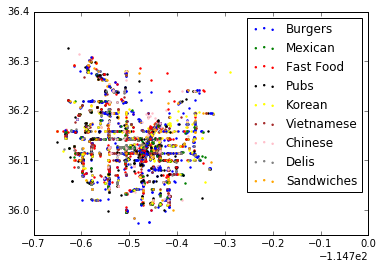

In [20]:
# Same way
# GMM scatter plot
GMM_predict = gmix.fit_predict(D.toarray())
colors = ['blue', 'green', 'red', 'black', 'yellow', 'brown', 'pink', 'grey', 'orange']
for i in range(0, len(parsed_data)):
    X = parsed_data[i]['longitude']
    Y = parsed_data[i]['latitude']
    if (GMM_predict[i] == 0):
        plta = plt.scatter(x = X, y = Y, color = colors[0], s = 2)
    elif (GMM_predict[i] == 1):
        pltb = plt.scatter(x = X, y = Y, color = colors[1], s = 2)
    elif (GMM_predict[i] == 2):
        pltc = plt.scatter(x = X, y = Y, color = colors[2], s = 2)
    elif (GMM_predict[i] == 3):
        pltd = plt.scatter(x = X, y = Y, color = colors[3], s = 2)
    elif (GMM_predict[i] == 4):
        plte = plt.scatter(x = X, y = Y, color = colors[4], s = 2)
    elif (GMM_predict[i] == 5):
        pltf = plt.scatter(x = X, y = Y, color = colors[5], s = 2)
    elif (GMM_predict[i] == 6):
        pltg = plt.scatter(x = X, y = Y, color = colors[6], s = 2)
    elif (GMM_predict[i] == 7):
        plth = plt.scatter(x = X, y = Y, color = colors[7], s = 2)
    elif (GMM_predict[i] == 8):
        plti = plt.scatter(x = X, y = Y, color = colors[8], s = 2)
plt.scatter(x = -114.8, y = 36.35, s=0)
plt.legend((plta, pltb, pltc, pltd, plte, pltf, pltg, plth, plti), 
           (gmm_result[0][0], 
            gmm_result[1][0], 
            gmm_result[2][0], 
            gmm_result[3][0],
            gmm_result[4][0],
            gmm_result[5][0],
            gmm_result[6][0],
            gmm_result[7][0],
            gmm_result[8][0]))

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

In [42]:
# Kmeans outlier
# We have already calculate the order centroids in the previous step
# Now we just need to get the last element of order_centroids, which are the outliers of every cluster
for i in range (0, 9):
    data = parsed_data[order_centroids[i, -2]]
    print(data['categories'], data['longitude'], data['latitude'])

['Fast Food', 'Hot Dogs', 'Sandwiches', 'Restaurants'] -115.077968956286 36.1592640772251
['Vegetarian', 'Thai', 'Vegan', 'Restaurants'] -115.142594814388 36.1424875211701
['Fast Food', 'Chicken Wings', 'Restaurants'] -115.1764027 36.1774463
['Chinese', 'Restaurants'] -115.160418 36.188135
['Korean', 'Restaurants'] -115.1409598 36.143672
['Sushi Bars', 'Japanese', 'Restaurants'] -115.1409598 36.143672
['Korean', 'Barbeque', 'Restaurants'] -115.1409598 36.143672
['Mexican', 'Restaurants'] -115.1409598 36.143672
['Fast Food', 'Chicken Wings', 'Restaurants'] -115.137 36.1451


Observation: The category has little overlap in the outlier, only Fast food and chicken has overlap in the above data.
location (longitude and latitude) are more likely to be in the corner side, which are far away from the center

In [64]:
# Hierarchy outlier
from scipy.spatial import distance
import sys
A = D.toarray()
hac_cen = [None]*11
hac_num = [None]*10
c = hac.centroid(z)
for i in range(0, len(T)):
    if (hac_cen[T[i]] is None):
        hac_cen[T[i]] = [0]*208
    hac_cen[T[i]] = hac_cen[T[i]] + A[i]

new_list = []
for i in range(0, 100):
    if (len(new_list) == 10):
        break
    data = parsed_data[T[i]]
    if (data in new_list):
        continue
    new_list.append(data)

for data in new_list:
    print(data['categories'], data['longitude'], data['latitude'])
    

['Pubs', 'Bars', 'Nightlife', 'Irish', 'Restaurants'] -115.1178915 36.017605
['Vietnamese', 'Chinese', 'Restaurants'] -115.193971 36.126177
['Pizza', 'Restaurants'] -115.1074743 35.9992047
['Latin American', 'Colombian', 'Restaurants'] -115.207747 36.142935
['Delis', 'Italian', 'Sandwiches', 'Restaurants'] -115.187588 36.1455961
['Vietnamese', 'Restaurants'] -115.1959803 36.1253808
['Burgers', 'American (Traditional)', 'Fast Food', 'Restaurants'] -115.1913849 36.1974092
['Fast Food', 'Sandwiches', 'Restaurants'] -115.206002 36.130335
['Sandwiches', 'Restaurants'] -115.206316 36.1433258
['Chinese', 'Restaurants'] -115.197904 36.125908


In [65]:
# GMM outlier
A = D.toarray()
hac_cen = [None]*11
hac_num = [None]*10
for i in range(0, len(GMM_predict)):
    if (hac_cen[GMM_predict[i]] is None):
        hac_cen[GMM_predict[i]] = [0]*208
    hac_cen[GMM_predict[i]] = hac_cen[GMM_predict[i]] + A[i]

new_list = []
for i in range(0, 100):
    if (len(new_list) == 10):
        break
    data = parsed_data[GMM_predict[i]]
    if (data in new_list):
        continue
    new_list.append(data)

for data in new_list:
    print(data['categories'], data['longitude'], data['latitude'])

['Burgers', 'American (Traditional)', 'Fast Food', 'Restaurants'] -115.1913849 36.1974092
['Wine Bars', 'Bars', 'Restaurants', 'Nightlife', 'Italian'] -115.3040091 36.1936092
['Fast Food', 'Sandwiches', 'Restaurants'] -115.206002 36.130335
['Vietnamese', 'Chinese', 'Restaurants'] -115.193971 36.126177
['Delis', 'Italian', 'Sandwiches', 'Restaurants'] -115.187588 36.1455961
['Pubs', 'Bars', 'Nightlife', 'Irish', 'Restaurants'] -115.1178915 36.017605
['Pizza', 'Restaurants'] -115.1074743 35.9992047
['Chinese', 'Restaurants'] -115.197904 36.125908
['Latin American', 'Colombian', 'Restaurants'] -115.207747 36.142935


Give a detailed analysis comparing the results you obtained from the 3 techniques. **(10 pts)**

Comparison and analysis
By oberserving the scatter plot, location (longitude and latitude) weighs much in Kmeans than in Hierarchy and GMM, which can be seen from the distribution of the spot.

Parameter difference: Hierarchy clustering doesn't need specify cluster or components. While kmeans needs to specify cluster number, and GMM needs to specify component number.

Kmeans is a way of hard clustering (we can see from the scatter plot), which makes thing not A then B, but GMM is a soft clustering, and makes things more reasonable. Hierarchy clustering, compared with Kmeans and GMM, is in the middle.
For example, in China town, there could be steakhouse and sushi food, etc. It's nonsense to classify all the restaurant in one category. From this side, GMM and hierarchy is more reasonable than Kmeans in this problem. In other word, some time kmeans draw unreasonable clusters, hierarchical clustering and GMM are more likely to correspond to taxonomies.

Time Complexity:
Kmeans is linear in the number of data objects O(n)
Hierarchical clustering algorithms is quadratic O(n^2)



----------